# Portfolio 2: Analysing COVID-19 Data

For the second portfolio we'll look at the most relevant dataset to our lives at the moment: the global spread of COVID-19.   There is an open dataset avaialable that is updated often showing the number of cases in different regions of the world.  This is the source of the graphs and visualisations that you'll see on the news. 

Here are some sample stories for reference:

* [From the ABC](https://www.abc.net.au/news/2020-03-26/coronavirus-covid19-global-spread-data-explained/12089028)
* [From the Guardian](https://www.theguardian.com/australia-news/datablog/ng-interactive/2020/apr/06/coronavirus-cases-in-australia-map-curve-confirmed-numbers-stats-how-many-covid-19-nsw-by-postcode-maps-victoria-live-data-qld-sa-wa-tas-nt-act-latest-statistics)
* [Coronavirus in Australia](https://www.covid19data.com.au/)
* [ArcGIS Dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) Johns Hopkins


In [4]:
#Importing libraries
import pandas as pd
import pandas.util.testing
import pandas.testing
import numpy as np
from matplotlib import pyplot as plt
from datetime import timedelta
plt.style.use('seaborn')
%matplotlib inline
import plotly
import plotly.express as px
import plotly.graph_objects as go
import datetime
from datetime import datetime
import statistics as st
import scipy
from pylab import rcParams
import seaborn as sb
from scipy.stats.stats import pearsonr
rcParams['figure.figsize'] = 10,9
sb.set_style('whitegrid')
from scipy.stats import ttest_ind
pd.set_option('mode.chained_assignment', None)


## Getting the Data

The first step is to get a copy of the raw data.  The data is being made available by Johns Hopkins University in [this GitHub repository](https://github.com/CSSEGISandData/COVID-19). We're interestd in the global confirmed cases dataset but you can also get data on deaths and recovered cases.  

You can either download a copy of the data into your project or just read it from the URL. The advantage of reading the URL is that you'll get live updates, but this might make it harder for you to repeat your experiments if the data changes.  Also, you would be making new requests for data every time you ran your worksheet putting load on the server (and your own network connection).  Consider downloading a copy as you are developing your worksheet and then switching to the live version once everything is debugged. (Eg. you could clone the github repository and copy the relevant data file into this project).

In [5]:
# loading the live dataset, assumes a working network connection
covid_data_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
covid = pd.read_csv(covid_data_url)
covid.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,5639,6053,6402,6664,7072,7653,8145,8676,9216,9998
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,898,916,933,946,948,949,964,969,981,989
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,6442,6629,6821,7019,7201,7377,7542,7728,7918,8113
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,761,761,761,761,761,761,762,762,762,762
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,48,48,48,48,50,52,52,58,60,61


## Explore the Data

The format of this data is one row per geographical region with columns for Lat/Long and then one column for each day's data.  Most regions are countries but in some cases, as in Australia, they are states.  

For the analysis we want to do we'll look at data for countries only, so the first operation on the data frame is to combine all of the rows for countries like Australia that are split into states.  We then want to drop the non-numeric columns to leave us with just the numbers on each day for each country.  This can be done using the [`groupby`](https://pandas.pydata.org/docs/getting_started/10min.html#grouping) method and the [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) method.  We can use these to make a new dataframe containing just the numerical data.

In [6]:
#Grouping on the basis of Country 
CovidGroupedData = covid.groupby('Country/Region').sum()

#Dropping Lat and long
GroupedData_Drop = CovidGroupedData.drop(['Lat', 'Long'],axis = 1)

# Dropping columns that have complete 0 records in a column
NumNumericGroup = GroupedData_Drop.loc[:, (GroupedData_Drop != 0).any(axis=0)]

#Reindex to see new grouped data
GroupedData_Clean = NumNumericGroup.reset_index()

#Checking Columns of grouped data
GroupedData_Clean.columns

Index(['Country/Region', '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20',
       '1/27/20', '1/28/20', '1/29/20', '1/30/20',
       ...
       '5/14/20', '5/15/20', '5/16/20', '5/17/20', '5/18/20', '5/19/20',
       '5/20/20', '5/21/20', '5/22/20', '5/23/20'],
      dtype='object', length=124)

You can now select just the data for one country [using the `loc` method](https://pandas.pydata.org/docs/getting_started/10min.html#selection) since the new dataframe will have the grouped values (Countries) as the row labels. Select the data for one country (you choose which) and plot it.  You should see the exponential rise in case numbers over time.

In [7]:
# Using loc to look for country 'US'
CovidUS = GroupedData_Clean.loc[GroupedData_Clean['Country/Region'] == 'US']

# Stacking table to retrive year and month part from date field
CovidStack = CovidUS.stack()

# Reseting the index to view stacked data
Coviddata1 = CovidStack.reset_index()

# Cleaning the column name
Coviddata1['Date'] =  Coviddata1['level_1']
CovidClean1 = Coviddata1[['Date',0]]
CovidClean1.columns = ['Date', 'No of Cases']
DropFirstrow = CovidClean1[ CovidClean1['Date'] == 'Country/Region' ].index
DropFirstrow

# Delete these row indexes from dataFrame
CovidClean1.drop(DropFirstrow , inplace=True)

# Converting Parsed Date to date time
CovidClean1['ParsedDate'] = pd.to_datetime(CovidClean1.Date)

# Selecting Specific columns
CovidClean2 = CovidClean1[['No of Cases','ParsedDate']]

# Grouped data based on semi-monthly
dt = CovidClean2.groupby([pd.Grouper(key='ParsedDate', freq='SM')])['No of Cases'].sum().reset_index().sort_values('ParsedDate')

# Coverting to string and taking left 6 
dt['ParsedDate'] = dt.astype(str)
dt['FinalParsedDate'] =  dt['ParsedDate'].str[6:]

# Cleaning the string
dt['Parsed Date'] = dt['FinalParsedDate'].replace({'-':'/'}, regex=True)

# Final Parsed data set
dt_Final = dt[['No of Cases', 'Parsed Date']]

# Filtering to remove data from 4/30
dt_FinalCOVID = dt_Final[dt_Final['Parsed Date'] >= '4/30' ].index

# Dropping data from 4/30
dt_Final.drop(dt_FinalCOVID , inplace=True)

# Viewing tail records
dt_Final.tail()

,No of Cases,Parsed Date
2,400,2/15
3,11327,2/29
4,888589,3/15
5,5990057,3/31
6,12652195,4/15


4/15


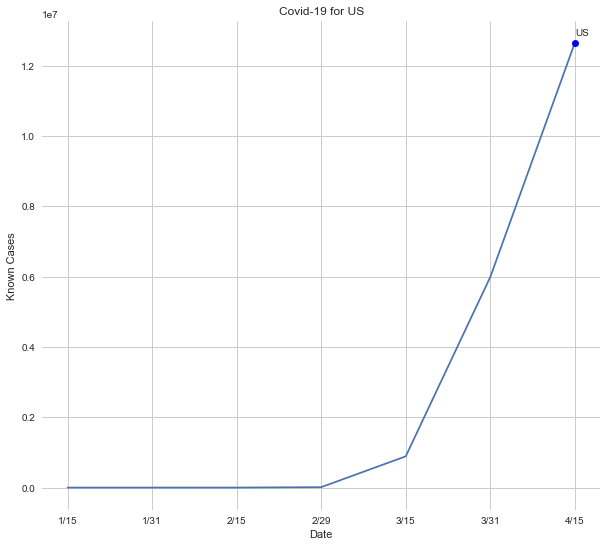

In [8]:
# Storing the result in a X and Y cordinate
x = dt_Final['Parsed Date']
y = dt_Final['No of Cases']

# Creating a plot 
fig = plt.figure()
ax = fig.add_subplot(111)
line, = ax.plot(x, y)

# Taking maximum point to annotate the country name
ymax = max(y)         
xpos = x.index.max()
xmax = x[xpos]
print(xmax)
ax.annotate('US', xy=(xmax, ymax+200000), xytext=(xmax, ymax+200000)
            )
ax.plot(xmax,ymax,'bo')
plt.xlabel('Date')
plt.ylabel('Known Cases')
plt.title("Covid-19 for US")
plt.show()

__Interpretation:-__ For US, the COVID cases remain negligible starting from 1/15 to 2/29. We see an increment in cases from 2/19 to 3/15 and from 3/15 onwards, we can see an exponential increase of COVID cases. 

## Comparing Countries

One of the classic displays in the news is the comparison between countries.  Select a number of countries and plot their data on the same graph to reproduce this visualisation. Suitable countries would be those who have significant outbreaks - China, USA, Italy, UK, Australia. 

In [9]:
# Using loc to look for countries like 'US', 'China', 'Australia' and 'Italy'
CovidSpecificCountries = GroupedData_Clean.loc[GroupedData_Clean['Country/Region'].isin(['US','China','Australia','Italy'])]
CovidSpecificCountries

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20
8,Australia,0,0,0,0,4,5,5,6,9,...,7019,7035,7044,7054,7068,7072,7081,7095,7099,7114
36,China,548,643,920,1406,2075,2877,5509,6087,8141,...,84029,84038,84044,84054,84063,84063,84063,84063,84081,84084
85,Italy,0,0,0,0,0,0,0,0,0,...,223096,223885,224760,225435,225886,226699,227364,228006,228658,229327
174,US,1,1,2,2,5,5,5,5,5,...,1417774,1442824,1467820,1486757,1508308,1528568,1551853,1577147,1600937,1622612


In [10]:
# Using Melt to group data based on countries and perform pivort
CovidSpecificCountries_Melt = CovidSpecificCountries.melt(id_vars = ['Country/Region'])
CovidSpecificCountries_Melt

,Country/Region,variable,value
0,Australia,1/22/20,0
1,China,1/22/20,548
2,Italy,1/22/20,0
3,US,1/22/20,1
4,Australia,1/23/20,0
...,...,...,...
487,US,5/22/20,1600937
488,Australia,5/23/20,7114
489,China,5/23/20,84084
490,Italy,5/23/20,229327


In [11]:
#Converting to date and renaming columns
CovidSpecificCountries_Melt['Date'] = pd.to_datetime(CovidSpecificCountries_Melt.variable)
CovidSpecificCountries_Cleaned = CovidSpecificCountries_Melt[['Country/Region','Date', 'value']]

# Grouping data by taking semi-monthly dates and parsing date field
dt1 = CovidSpecificCountries_Cleaned.groupby(['Country/Region', pd.Grouper(key='Date', freq='SM')])[['value','Country/Region']].sum().reset_index().sort_values('Date')
dt1['Parsed Dates'] = dt1['Date'].astype(str)
dt1['Parsed Date'] =  dt1['Parsed Dates'].str[6:]
dt1['Parsed Date'] = dt1['Parsed Date'].replace({'-':'/'}, regex=True)

# Choosing specific fields and dropping data from 4/30 so that we have consistent result
CovidSpecificCountries_Final = dt1[['value', 'Country/Region','Parsed Date']]
CovidSpecificCountries_Final.columns = ['Known Cases', 'Country/Region','Parsed Date']
CovidSpecificCountries_Final_Cleaned = CovidSpecificCountries_Final[CovidSpecificCountries_Final['Parsed Date'] >= '4/30' ].index
CovidSpecificCountries_Final.drop(CovidSpecificCountries_Final_Cleaned , inplace=True)
CovidSpecificCountries_Final.tail()

,Known Cases,Country/Region,Parsed Date
5,86513,Australia,3/31
33,12652195,US,4/15
24,2794442,Italy,4/15
6,99486,Australia,4/15
15,1257055,China,4/15


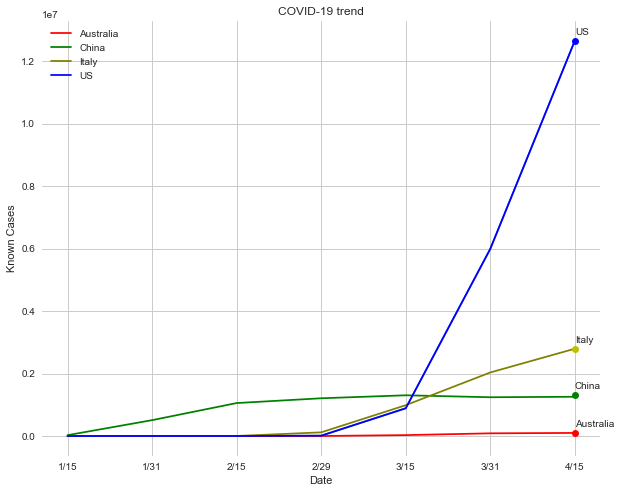

In [12]:
# Taking maximum value to show the countries in the plot
CovidSpecificCountries_Max = CovidSpecificCountries_Final.groupby(['Country/Region'], sort=False)[['Known Cases','Parsed Date']].max()
CovidSpecificCountries_Max_Reset = CovidSpecificCountries_Max.reset_index()
CovidSpecificCountries_Max_Reset

#Choosing colors of specific countries
colors = {'Australia':'red', 'China':'green', 'Italy':'olive', 'US':'blue'}

# Using subplots
fig, ax = plt.subplots(figsize=(10,8))
line, = ax.plot(x, y)
for label, df in CovidSpecificCountries_Final.groupby('Country/Region'):
    df.plot(kind='line', x = "Parsed Date", y = "Known Cases", ax=ax,label=label, color=colors[label])
colors1 = {'Australia':'ro', 'China':'go', 'Italy':'yo', 'US':'bo'}

# To add country details in the graph
for Country,value,date in  zip(CovidSpecificCountries_Max_Reset['Country/Region'], CovidSpecificCountries_Max_Reset['Known Cases'], CovidSpecificCountries_Max_Reset['Parsed Date']):
        ymax = value         
        xmax = date
        ax.annotate(Country, xy=(xmax, ymax+200000), xytext=(xmax, ymax+200000))
        ax.plot(xmax,ymax,colors1[Country])
        
# Adding labels to the graph        
plt.xlabel('Date')
plt.ylabel('Known Cases')
plt.title('COVID-19 trend')
plt.show()


__Interpretation__:- 
1. For US, the COVID cases remain negligible starting from 1/15 to 2/29. We see an increment in cases from 2/19 to 3/15 and from 3/15 onwards, we can see an exponential increase of COVID cases. 
2. For China, we see increment in COVID cases starting from 1/15 to 2/15. From 2/15 onwards, the cases remain stable.
3. For Italy, we see negligible cases starting from 1/12 to 2/19. However, we see increment in the number of cases starting 2/29 to 4/15.
4. For Australia, we see negligible cases starting from 1/15 to 4/15.


__A very useful visualisation shows the data for different countries aligned from the time that they have 100 confirmed cases.  To create this figure, you need to take only the part of each time series after the value is greater than or equal to 100 and then plot this starting at 0 on the x-axis.  This is a bit more involved but will allow you to explore Pandas a bit more.__

In [13]:
# Creating a function to calculate time series based on country name

def CaltimeSeries(countryname):
    li = []
    GroupedData_Melt =  GroupedData_Clean.melt(id_vars = ['Country/Region'])
    GroupedData_CountryName = GroupedData_Melt[GroupedData_Melt["Country/Region"] == countryname]
    GroupedData_CountryName_gtr100 = GroupedData_CountryName[GroupedData_CountryName["value"]>100]
    GroupedData_CountryName_gtr100['Date'] = pd.to_datetime(GroupedData_CountryName_gtr100.variable)
    a_df=np.unique(GroupedData_CountryName_gtr100['Date'], axis=0)
    UniqDate= pd.DataFrame(a_df)
    UniqDate['New_ID'] = UniqDate.index
    UniqDate20days = UniqDate.groupby([pd.Grouper(key=0, freq='20D')])['New_ID'].min().reset_index().sort_values(0)
    CountryGrp = GroupedData_CountryName_gtr100.groupby(['Country/Region', pd.Grouper(key='Date', freq='20D')])[['value','Country/Region']].sum().reset_index().sort_values('Date')
    MergeFinal= pd.merge(CountryGrp, UniqDate20days, how='left', left_on='Date', right_on=0)
    dt_FinalCOVID = MergeFinal[MergeFinal[0]> '2020-04-12' ].index
    MergeFinal.drop(dt_FinalCOVID , inplace=True)
    FinalMerge = MergeFinal[["Country/Region","Date","value","New_ID"]]
    FinalMerge.columns = ["Country/Region","Date","Know Cases","Days since 100th case"]
    li.append(FinalMerge)
    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame
 

In [15]:
# Calculating time series of specific countries
US = CaltimeSeries('US')
Australia = CaltimeSeries('Australia')
Italy = CaltimeSeries('Italy')
China = CaltimeSeries('China')
UK = CaltimeSeries('United Kingdom')
Taiwan = CaltimeSeries('Taiwan*')

In [16]:
result = US.append([Australia,Italy,China,UK,Taiwan])

In [17]:
result

,Country/Region,Date,Know Cases,Days since 100th case
0,US,2020-03-03,125404,0
1,US,2020-03-23,5020722,20
2,US,2020-04-12,16568687,40
0,Australia,2020-03-10,26266,0
1,Australia,2020-03-30,116866,20
0,Italy,2020-02-23,99459,0
1,Italy,2020-03-14,1339959,20
2,Italy,2020-04-03,3116742,40
0,China,2020-01-22,321086,0
1,China,2020-02-11,1430215,20


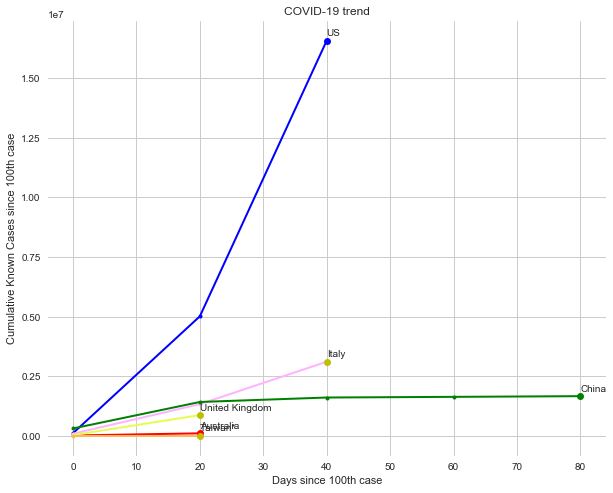

In [18]:
# Taking maximum value to add annotation based on each countries
SpecificCountiriesMax = result.groupby(['Country/Region'], sort=False)[['Know Cases','Days since 100th case']].max()
SpecificCountiriesMaxResult = SpecificCountiriesMax.reset_index()
SpecificCountiriesMaxResult

#Using subplots 
fig, ax = plt.subplots(figsize=(10,8))
ax.plot( 'Days since 100th case', 'Know Cases', data=US, marker='.', markerfacecolor='blue', markersize=8, color='blue', linewidth=2,label="US")
ax.plot( 'Days since 100th case', 'Know Cases', data=Australia, marker='.', color='red', markersize=8, linewidth=2,label="Australia")
ax.plot( 'Days since 100th case', 'Know Cases', data=Italy, marker='.', color='#ffb3ff', markersize=8,linewidth=2,label="Italy")
ax.plot( 'Days since 100th case', 'Know Cases', data=China, marker='.', color='green',markersize=8, linewidth=2,label="China")
ax.plot( 'Days since 100th case', 'Know Cases', data=UK, marker='.', color='#eafb50',markersize=8, linewidth=2,label="United Kingdom")
ax.plot( 'Days since 100th case', 'Know Cases', data=Taiwan, marker='.', color='#f7bb5f', markersize=8,linewidth=2,label="Taiwan")

# Using colors to distinguish countries
colors = {'Australia':'ro', 'China':'go', 'Italy':'yo', 'US':'bo','United Kingdom':'yo','Taiwan*':'yo'}

# Using loop to show different countries 
for Country,Cases,Days in  zip(SpecificCountiriesMaxResult['Country/Region'], SpecificCountiriesMaxResult['Know Cases'], SpecificCountiriesMaxResult['Days since 100th case']):
        ymax = Cases         
        xmax = Days
        ax.annotate(Country, xy=(xmax, ymax+200000), xytext=(xmax, ymax+200000))
        ax.plot(xmax,ymax,colors[Country])

plt.xlabel('Days since 100th case')
plt.ylabel('Cumulative Known Cases since 100th case')
plt.title('COVID-19 trend')
plt.show()

__Interpretation:-__ The plot shows data for different countries aligned from the time they have 100 confirmed cases. For US, we can how rapidly the virus was spread in next 40 days. However, for china, we see increase in number of cases for first 20 days, but later the cases remain stable. For Italy, initially for first 20 days, the number of cases were in line with china. However, after 20 days, we see Italy overtaking china. The COVID cases in United Kingdom is slightly below the china. It seems difficult to compare early days of each outbreak as they are compressed down the bottom of the chart. To aid with this, we need to use a logarithmic scale with is shown towards the end of this portfolio.

## Normalisation by Population

The raw data includes the overall count of cases in each country. Clearly small countries will have smaller overall values than large countries.  It would be interesting to see whether the number of cases in China and the US was more per-capita than those in other countries and find which country has the highest number as a proportion of the population. (A good way to measure this is the number of cases per million people in the population. If a country has 25 cases and a population of 2.5 million they would have 10 cases per million).

To answer these questions we need population data. I'll present two possible sources of data (there are more of course) [datahub.io](https://datahub.io/JohnSnowLabs/population-figures-by-country) has data per country up to 2016 in a handy CSV format. The [United Nations Population Dynamics page](https://population.un.org/wpp/Download/Standard/CSV/) has data that predicts populations up to 2100 in CSV format.  Use one of these data sets to compute the number of confirmed cases for each country per million population.   Create a new plot with this data. Create a plot to compare the most recent day's data - which country has the most cases per million right now? 

_Note, to use the population data you'll have to make sure that the country names match up in the different data sets. There's no magic way to do this, either you edit one of the datasets or write code to modify the data once you read it in.  The second of these is better because it makes it easy for someone else to repeat your analysis._

In [20]:
#Applying melt to group and pivot the table
CovidNor = GroupedData_Clean.melt(id_vars = ['Country/Region'])

# Using lookup table to match country code
Lookuptable = pd.read_csv('data/Portfolio2/Country-Code.csv')

# Downloading data from datahub.io
TotalPop = pd.read_csv('data/Portfolio2/population-figures-by-country.csv')

#Merging Covid data with total population
CovMergeFinal= pd.merge(CovidNor, Lookuptable, how='left', left_on='Country/Region', right_on='Country/Region')
CovMergePopulation = pd.merge(CovMergeFinal, TotalPop, how='left', left_on='Country', right_on='Country_Code')
CovMergePopulationClean = CovMergePopulation[['Country/Region','variable','value','Year_2016']]
CovMergePopulationClean["Population in Million"] = round(CovMergePopulationClean['Year_2016']/1000000,2)
CovMergePopulationClean = CovMergePopulationClean.reset_index()

# Removing cases where we have less the 1 million population in order to calculate of cases per million.
CovMergePopulationCleangtr1 = CovMergePopulationClean[CovMergePopulationClean["Population in Million"] >=1]
CovMergePopulationCleangtr1
CovMergePopulationgtr1Clean = CovMergePopulationCleangtr1[['Country/Region','variable','value', 'Population in Million']]
CovMergePopulationgtr1Clean.sort_values('Country/Region')
CovMergePopulationgtr1Clean.columns = ['Country/Region', 'Date','Cases','Population in Million']
CovMergePopulationgtr1Clean['Cases Per Million'] = round(CovMergePopulationgtr1Clean['Cases']/CovMergePopulationgtr1Clean['Population in Million'],2)
CovMergePopulationgtr1CleanCases =  CovMergePopulationgtr1Clean.groupby(['Country/Region','Cases Per Million','Date'])['Cases'].sum().to_frame()
CovMergePopulationFinal = CovMergePopulationgtr1CleanCases.dropna()
CovMergePopulationFinal
CovMergePopulationFinalClean =  CovMergePopulationFinal.groupby(['Country/Region','Cases Per Million','Date'])['Cases'].sum().to_frame()
CovPopulationFinalClean = CovMergePopulationFinalClean.reset_index()
CovPopulationFinalClean['Date'] = pd.to_datetime(CovPopulationFinalClean.Date)
CovPopulationFinalClean[100:120]

,Country/Region,Cases Per Million,Date,Cases
100,Afghanistan,67.37,2020-05-01,2335
101,Afghanistan,71.23,2020-05-02,2469
102,Afghanistan,78.02,2020-05-03,2704
103,Afghanistan,83.50,2020-05-04,2894
104,Afghanistan,93.02,2020-05-05,3224
105,Afghanistan,97.86,2020-05-06,3392
106,Afghanistan,102.80,2020-05-07,3563
107,Afghanistan,109.00,2020-05-08,3778
108,Afghanistan,116.36,2020-05-09,4033
109,Afghanistan,127.01,2020-05-10,4402


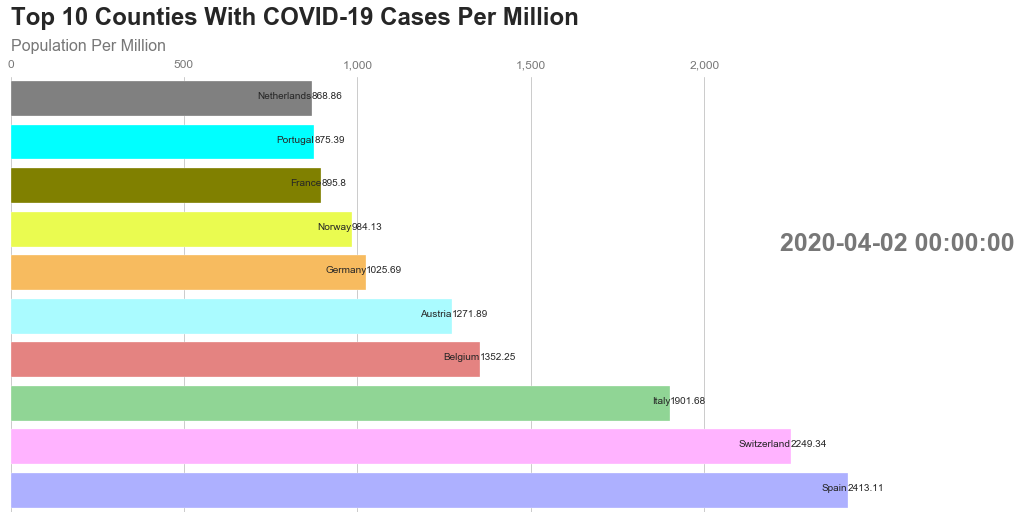

In [18]:
# Creating a running Bar graph that shows top 10 countries with most cases per million
from time import sleep
from matplotlib import animation
import matplotlib.ticker as ticker

# We will be running Bar Graph starting 20200401
CovDate = CovPopulationFinalClean[CovPopulationFinalClean['Date'] > '2020-04-01']
CovDateFinal = CovDate['Date']
CovDateFinalDrop = CovDateFinal.drop_duplicates()
CovDatFinal  =CovDateFinalDrop.reset_index()
CovDatFinals = CovDatFinal['Date']
CovDatFinals 


#top 10 country having Cases per million population
list_countries = ['Qatar', 'Bahrain', 'Singapore', 'Ireland', 'Spain','Belgium','US','Kuwait','United Kingdom','Italy']
list_colors = ['#adb0ff', '#ffb3ff', '#90d595', '#e48381', '#aafbff','#f7bb5f','#eafb50','olive','cyan','gray']
#Subplots
fig, ax = plt.subplots(figsize=(15, 8))
def plot_bar(some_date):
    df2 = CovPopulationFinalClean[CovPopulationFinalClean['Date'].eq(some_date)]
    ax.clear()
    # Only take Confirmed column in descending order
    df3 = df2.sort_values(by = 'Cases Per Million', ascending = False)
    # Select the top 10  countries having cases per million population 
    df4 = df3[['Country/Region','Cases Per Million']].head(10)
    # To slow down the animation
    sleep(4)  
    # ax.barh() makes a horizontal bar plot.
    for i, (value, name) in enumerate(zip(df4['Cases Per Million'], df4['Country/Region'])):
        ax.text(value, i,     name,            ha='right')  # Tokyo: name
        ax.text(value, i,     value,           ha='left')   # 38194.2: value
    # Coloring and transforming data    
    ax.text(1.2, 0.6, some_date, transform=ax.transAxes, color='#777777', size=25, ha='right', weight=800)
    ax.text(0, 1.06, 'Population Per Million', transform=ax.transAxes, size=16, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    # Adding header to bar chart
    ax.text(0, 1.12, 'Top 10 Counties With COVID-19 Cases Per Million',
            transform=ax.transAxes, size=24, weight=600, ha='left')
    plt.box(False)
    return ax.barh(df4['Country/Region'], df4['Cases Per Million'], color= list_colors)

# using FuncAnimation to show data till most recent days
my_anim = animation.FuncAnimation(fig = fig, func = plot_bar,
                    frames= CovDatFinals,interval = 1000)
my_anim


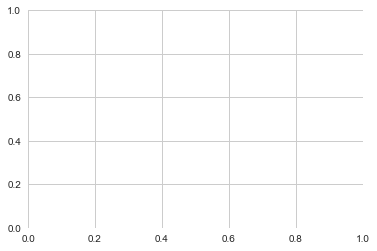

In [62]:
#path_mp4 = r'data\CovidCases.mp4' 
path_mp4 = r'data\CovidCases.mp4' 
my_anim.save(filename = path_mp4, writer = 'ffmpeg',
             fps=10,
             extra_args= ['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])



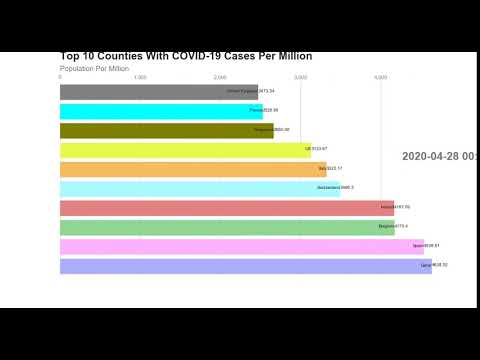

In [21]:
from IPython.display import Audio, Image, YouTubeVideo
# Added the video in youtube
YouTubeVideo(id='2BAj7PpHFgU',width =600,height =500)

__Interpretation:-__ From the mentioned video, we can see that Qatar has most cases per million.

## A Predictive Model

It is well understood that the spread of the virus follows an exponential pattern. This is because each infected person infects more than one new person on average, leading to exponential growth.  This is why the key to stopping the growth of the pandemic is to reduce the number of people infected by stopping contact and isolating infected poeple. 

An exponential curve has the equation $y = e^{mx}$. It can be converted to a linear relationship by taking the logarithm of each side: $log(y) = mx$.  This means that we can fit a linear regression model to the data as long as we take the log of the number of cases. 

Select a country with a clear exponential curve (for example, the US) and build a linear regression model to predict the log of the number of case.  Test how well the model fits the data. 

Now, select the data from China. This should show some divergence from the model since they have managed to slow the growth of cases.  Can you show from the model that China's data does not show exponential growth?   If China had not acted to stop the virus, how many cases would there be now according to this simple model? 

Can you use this metric to identify countries where the virus is under control and those where it is not? 

In [20]:
#Using libraries to predict the model
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
linear_model = LinearRegression(normalize = True,fit_intercept=True)
from sklearn.model_selection import train_test_split

Text(0.5, 1.0, 'COVID-19 trend')

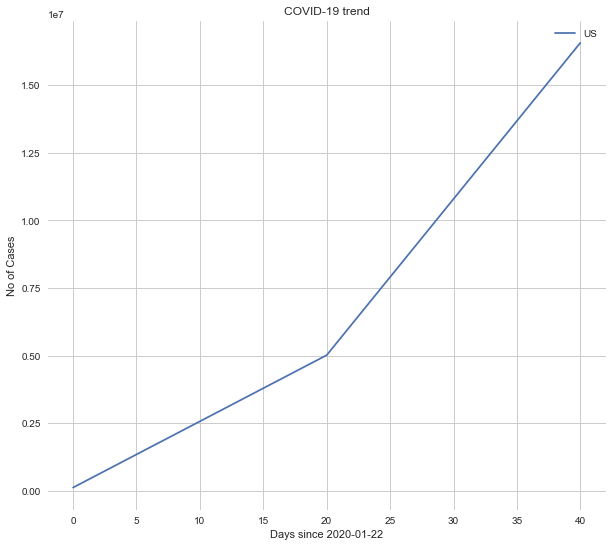

In [22]:
# Predicting cases for US
US = CaltimeSeries('US')
plt.plot(US['Days since 100th case'],US['Know Cases'],label = 'US')
plt.xlabel("Days since 2020-01-22")
plt.ylabel("No of Cases")
plt.legend()
plt.title('COVID-19 trend')


In [24]:
# Defining X and Y coordinates
X = US[['Days since 100th case']]
y = US['Know Cases']

# taking logarithmic value
log_y =  np.log(US['Know Cases'])
log_y

# Applying linear regression
LinReg = LinearRegression()
LinReg.fit(X,log_y)
print("For US, the intercept is:",LinReg.intercept_,'and the coefficient is:',LinReg.coef_)


For US, the intercept is: 12.155270414729243 and the coefficient is: [0.12209323]


__Interpretation:-__ We see a linear co-efficient of 0.122 and intercept of 12.15

In [26]:
# Predicting values
y_pred = LinReg.predict(X)
y_pred

array([12.15527041, 14.59713509, 17.03899976])

Text(0.5, 1.0, 'COVID-19 trend for US')

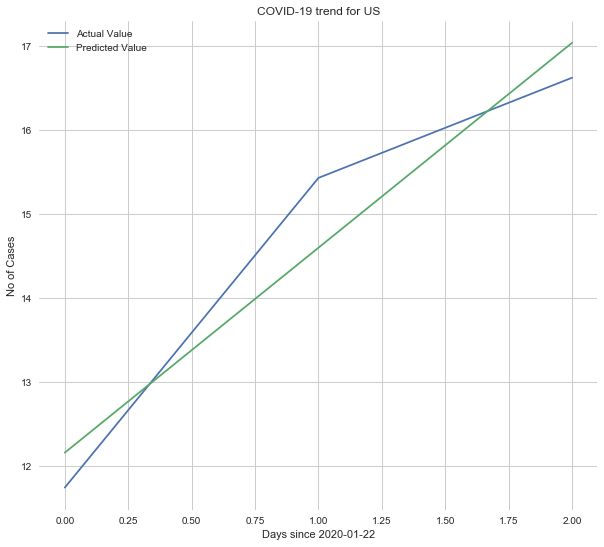

In [27]:
plt.plot(log_y, label = "Actual Value")
plt.plot(y_pred, label = "Predicted Value")
plt.legend()
plt.xlabel("Days since 2020-01-22")
plt.ylabel("No of Cases")
plt.title('COVID-19 trend for US')


In [28]:
print('r squared of the Prediction:(US)',LinReg.score(X,log_y))

r squared of the Prediction:(US) 0.9199136023765467


__Interpretation:-__ We can see that actual and predicted value for US matches closely with each other. The linear regression model is performing well and r square value is close to 1. The model fits well in predicting the data for US.

select the data from China. This should show some divergence from the model since they have managed to slow the growth of cases.  Can you show from the model that China's data does not show exponential growth?   If China had not acted to stop the virus, how many cases would there be now according to this simple model?

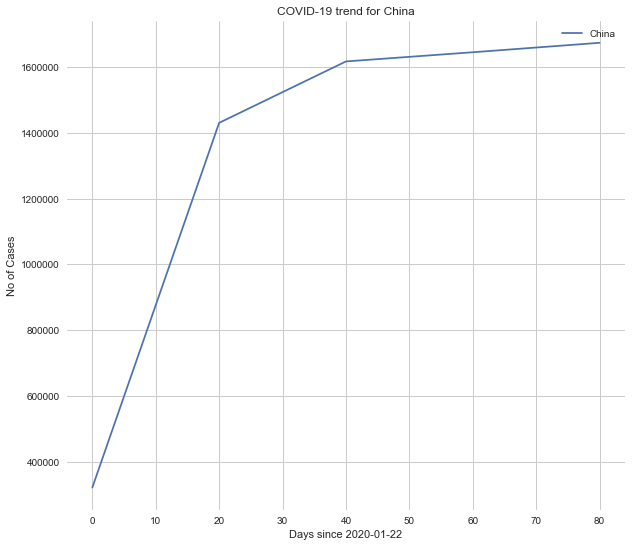

In [29]:
China = CaltimeSeries('China')
China
#dfUS1 = dfUS[dfUS['Days']>50]
plt.plot(China['Days since 100th case'],China['Know Cases'],label = 'China')
plt.xlabel("Days since 2020-01-22")
plt.ylabel("No of Cases")
plt.title('COVID-19 trend for China')
plt.legend()

In [30]:
# Defining X and Y Coordinate
X = China[['Days since 100th case']]
y = China['Know Cases']
LinReg = LinearRegression()
LinReg.fit(X,y)
print('For China Intercept is:',LinReg.intercept_,' and Coefficient is:',LinReg.coef_)

For China Intercept is: 753408.4  and Coefficient is: [14599.48]


In [31]:
y_pred1 = LinReg.predict(X)
y_pred1

array([ 753408.4, 1045398. , 1337387.6, 1629377.2, 1921366.8])

Text(0.5, 1.0, 'COVID-19 trend for China')

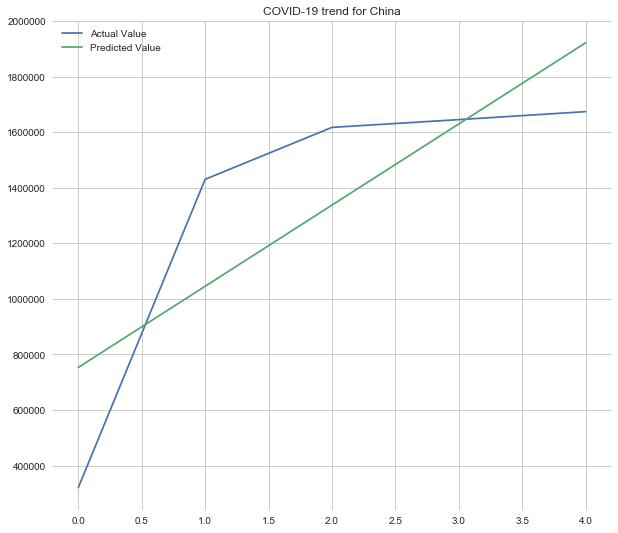

In [32]:
plt.plot(y, label = "Actual Value")
plt.plot(y_pred1, label = "Predicted Value")
plt.legend()
plt.title('COVID-19 trend for China')


In [33]:
print('r squared of the Prediction(China)',LinReg.score(X,y))

r squared of the Prediction(China) 0.6423126964088759


__Interpretation:-__ The linear regression model is not performing well and r square value is 64%. The model does not fit well in predicting the data for China.

Text(0.5, 1.0, 'COVID-19 trend')

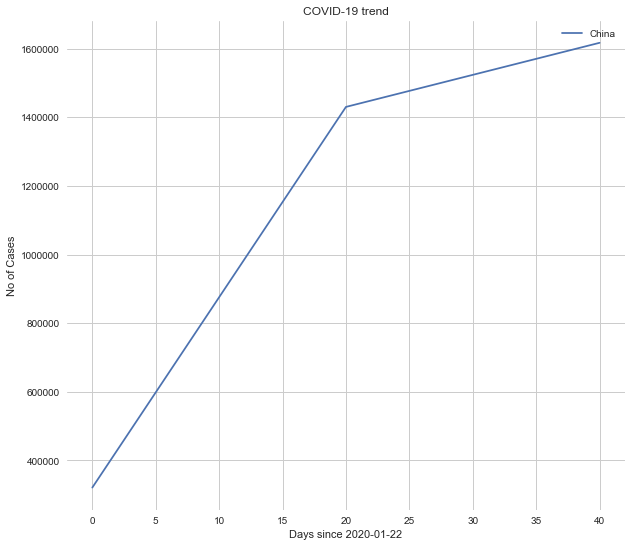

In [34]:
China = CaltimeSeries('China')

# If China had not acted to stop the virus, how many cases would there be now according to this simple model?
dfChina1 = China[China['Days since 100th case']<=40]
dfChina1
plt.plot(dfChina1['Days since 100th case'],dfChina1['Know Cases'],label = 'China')
plt.xlabel("Days since 2020-01-22")
plt.ylabel("No of Cases")
plt.legend()
plt.title('COVID-19 trend')


In [35]:
X = dfChina1[['Days since 100th case']]
y = dfChina1['Know Cases']
LinReg = LinearRegression()
LinReg.fit(X,y)
print('Intercept is:',LinReg.intercept_,'and Coefficient is:',LinReg.coef_)

Intercept is: 474804.66666666674 and Coefficient is: [32398.65]


In [36]:
y_pred1 = LinReg.predict(X)
y_pred1

array([ 474804.66666667, 1122777.66666667, 1770750.66666667])

If China had not acted to stop the virus,there would be above mentioned cases till now.

In [37]:
print('r squared of the Prediction:',LinReg.score(X,y))

r squared of the Prediction: 0.8555532718783158


__Interpretation__:- The r squared value show 85% for the inital 40 days of virus spread in china. The model perform well in predicting the cases if china had not acted to stop the spread of the virus. 

In [38]:
# Calculating logarithmic time series 
def Callogrithmictimeseries(countryname):
    li = []
    GroupedData_Clean1 =  GroupedData_Clean.melt(id_vars = ['Country/Region'])
    GroupedData_Clean2 = GroupedData_Clean1[GroupedData_Clean1["Country/Region"] == countryname]
    GroupedData_Clean3 = GroupedData_Clean2[GroupedData_Clean2["value"]>100]
    GroupedData_Clean3['variable'] = pd.to_datetime(GroupedData_Clean3.variable)
    a_df=np.unique(GroupedData_Clean3['variable'], axis=0)
    UniqVariable= pd.DataFrame(a_df)
    UniqVariable.index += 1
    UniqVariable['New_ID'] = UniqVariable.index
    UniqVariable
    UniqVariable20days = UniqVariable.groupby([pd.Grouper(key=0, freq='20D')])['New_ID'].min().reset_index().sort_values(0)
    UniqVariable20days
    CountryGrp = GroupedData_Clean3.groupby(['Country/Region', pd.Grouper(key='variable', freq='20D')])[['value','Country/Region']].sum().reset_index().sort_values('variable')
    CountryGrp
    MergeFinal= pd.merge(CountryGrp, UniqVariable20days, how='left', left_on='variable', right_on=0)
    MergeFinal1 = MergeFinal.groupby(['Country/Region'])['variable'].min().to_frame()
    MergeFinal2 = MergeFinal1.reset_index()
    MergeFinal
    MergeFinal['Log Of Known Cases'] =  np.log(MergeFinal['value'])
    MergeFinal
    dt_FinalCOVID = MergeFinal[MergeFinal[0] > '2020-04-12' ].index
    MergeFinal.drop(dt_FinalCOVID , inplace=True)
    MergeFinal
    p1 = []
    for Country,variable in zip(MergeFinal2['Country/Region'],MergeFinal2['variable']):
        p1.append(Country)
        p1.append(variable)
        p1.append(0)
        p1.append(0)
        p1.append(0)
        p1.append(0)
    p2 = pd.DataFrame(p1)
    p3 = p2.T
    p4 =p3.reset_index()
    p5 =pd.DataFrame(p4)
    p6  =p5[[0,1,2,3,4,5]]
    p6.columns = ['Country/Region','variable','value',0,'New_ID','Log Of Known Cases']
    p7 = p6
    p7
    append = MergeFinal.append(p7)
    append
    FinalMerge1 = append[["Country/Region","variable","value","New_ID",'Log Of Known Cases']]
    FinalMerge1.columns = ["Country/Region","Date","Known Cases","Days since 100th case",'Log Of Known Cases']
    dffinalcases = FinalMerge1.sort_values('Known Cases')
    dffinalcases1 = dffinalcases.reset_index()
    dffinalcases1
    li.append(dffinalcases1)
    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

In [39]:
USdf1 = Callogrithmictimeseries('US')
USdf1
AUdf2 = Callogrithmictimeseries('Australia')
AUdf2
ITdf3 = Callogrithmictimeseries('Italy')
ITdf3
CHdf4 = Callogrithmictimeseries('China')
UKdf5 = Callogrithmictimeseries('United Kingdom')
TAdf6 = Callogrithmictimeseries('Taiwan*')
resultFI = USdf1.append([AUdf2,CHdf4,ITdf3,UKdf5,TAdf6])
resultFI1 = resultFI.reset_index()
resultFI1

,level_0,index,Country/Region,Date,Known Cases,Days since 100th case,Log Of Known Cases
0,0,0,US,2020-03-03,0,0,0
1,1,0,US,2020-03-03,125404,1,11.7393
2,2,1,US,2020-03-23,5020722,21,15.4291
3,3,2,US,2020-04-12,16568687,41,16.623
4,0,0,Australia,2020-03-10,0,0,0
5,1,0,Australia,2020-03-10,26266,1,10.176
6,2,1,Australia,2020-03-30,116866,21,11.6688
7,0,0,China,2020-01-22,0,0,0
8,1,0,China,2020-01-22,321086,1,12.6795
9,2,1,China,2020-02-11,1430215,21,14.1733


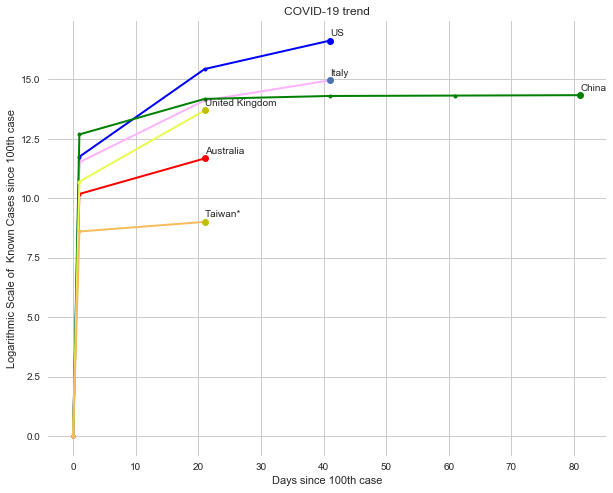

In [40]:
# Taking maximum value to add label in the plot
dfResult1 = resultFI.groupby(['Country/Region'], sort=False)[['Log Of Known Cases','Days since 100th case']].max()
dfResult2 = dfResult1.reset_index()
dfResult2

# Using subplots
fig, ax = plt.subplots(figsize=(10,8))
ax.clear()
#line, = ax.plot(x, y)
ax.plot( 'Days since 100th case', 'Log Of Known Cases', data=USdf1, marker='.', markerfacecolor='blue', markersize=8, color='blue', linewidth=2,label="US")
ax.plot( 'Days since 100th case', 'Log Of Known Cases', data=AUdf2, marker='.', color='red', markersize=8, linewidth=2,label="Australia")
ax.plot( 'Days since 100th case', 'Log Of Known Cases', data=ITdf3, marker='.', color='#ffb3ff', markersize=8,linewidth=2,label="Italy")
ax.plot( 'Days since 100th case', 'Log Of Known Cases', data=CHdf4, marker='.', color='green',markersize=8, linewidth=2,label="China")
ax.plot( 'Days since 100th case', 'Log Of Known Cases', data=UKdf5, marker='.', color='#eafb50',markersize=8, linewidth=2,label="United Kingdom")
ax.plot( 'Days since 100th case', 'Log Of Known Cases', data=TAdf6, marker='.', color='#f7bb5f', markersize=8,linewidth=2,label="Taiwan")

colors = {'Australia':'ro', 'China':'go', 'Italy':'o', 'US':'bo','United Kingdom':'yo','Taiwan*':'yo'}

for Country,Cases,Days in  zip(dfResult2['Country/Region'], dfResult2['Log Of Known Cases'], dfResult2['Days since 100th case']):
        ymax = Cases         
        xmax = Days
        ax.annotate(Country, xy=(xmax, ymax+0.2), xytext=(xmax, ymax+0.2))
        ax.plot(xmax,ymax,colors[Country])
plt.xlabel('Days since 100th case')
plt.ylabel('Logarithmic Scale of  Known Cases since 100th case')
plt.title('COVID-19 trend')
plt.show()

__Interpretation__:-By using the logarithmic plot, we can identify that for China, Australia, Taiwan, the virus is under control and for US and Italy, we see an exponential increase in the number of confirmed cases.